# Type II Equilibrium Plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
final_fig_path = "../CH_Manuscript/Figures/"
import sys
sys.path.insert(1, 'Functions')
from fitness_funs_non_dim import *
from group_w_pop_funs import *
from local_stability_funs import *
from scipy.integrate import solve_ivp
from sim_graph_funs import *
from scipy.optimize import fsolve, minimize, root


# First $x_m = 5$ (with $x_m = 10$, there's cycling... not shown but found previously)

In [2]:
H=1
x_max = 5
params_base = dict(η1 = 0.2, η2 = 0.4, A1 = 0.5, β1 = 8, β2 = 1, 
                   H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, r = 0, γ = 0, pop_process = True)

In [3]:
xvec = np.arange(1,x_max+1,1)
β1vec = np.arange(1,10,0.2)
Pvec = np.zeros(len(β1vec))
meanxvec = np.zeros(len(β1vec))
Fxvecs  = np.zeros((len(β1vec), x_max))
N1vec = Pvec.copy()
N2vec = Pvec.copy()

for i, β1 in enumerate(β1vec):
    params = params_base.copy()
    params['β1'] = β1
    initialstate = np.array([3, 0.5, 0.5, 3, *np.zeros(9)])
    t_f = 2000
    out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))
    T,N1,N2,P,Fxvec, mean_x = get_results(out2, 10)
    #N1_eq, N2_eq, F_eq, P_eq, mean_x_eq = get_equilibrium(params)
    Fxvecs[i,:] = Fxvec[:,-1]
    Pvec[i] = P[-1]
    N1vec[i] = N1[-1]
    N2vec[i] = N2[-1]
    meanxvec[i] = mean_x[-1]
    

In [4]:
stability_vec = np.ones(β1vec.shape)

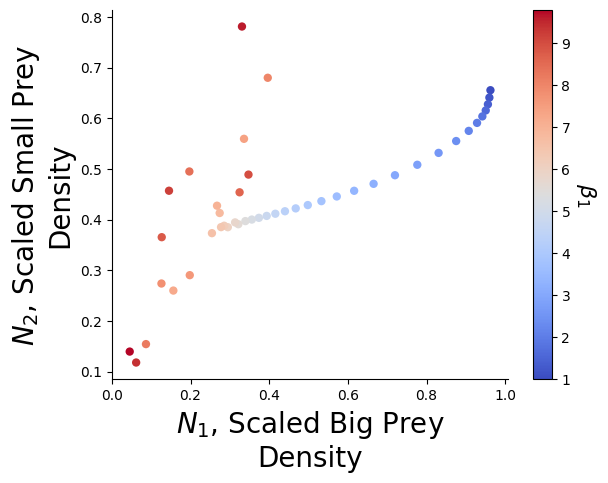

In [5]:
fig, ax = plt.subplots(1,1)
mask = stability_vec == 1
p = plt.scatter(N1vec[mask],N2vec[mask], c = β1vec, cmap = 'coolwarm', edgecolor='none')
cb = plt.colorbar(p, label = β1lab)
cb.set_label(label=β1lab, rotation = 270, fontsize = 16, labelpad = 20)
#plt.plot(N1vec,N2vec, 'k')
format_ax(ax,N1lab,N2lab)

Iterate to Equilibria

## Try solving equilibria

In [13]:
# given paramvec, paramkey, x_max, params

def get_equilibria_vary_param(paramvec, paramkey, x_max, **params):
    '''
    Get a list of equilibrium values corresponding to the parameters
    '''

    def iterate_to_eq(initialstate, t_f,params):
        '''
        try to iterate to eq in t_f time steps
        '''
        out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                    args=(True,params))
        T,N1,N2,P,Fxvec, mean_x = get_results(out2, 10)
        full_trajectory = T,N1,N2,P,Fxvec, mean_x
        N1,N2,P,mean_x = [ item[-1] for item in [N1,N2,P,mean_x]]
        F = Fxvec[:,-1]
        timederivatives = full_model(T[-1], [P,N1,N2,*F],True,params)
        success = np.any(np.array(timederivatives)<1e-8)
        
        
        return np.array([P, N1, N2, *F]), success, mean_x, full_trajectory




    xvec = np.arange(1,x_max+1,1)
    Pvec = np.zeros(len(paramvec))
    meanxvec = np.zeros(len(paramvec))
    Fxvecs  = np.zeros((len(paramvec), x_max))
    N1vec = Pvec.copy()
    N2vec = Pvec.copy()
    success_vec = Pvec.copy()
    stability_vec = Pvec.copy()
    
    for i, param in enumerate(paramvec):
        params = params_base.copy()
        params[paramkey] = param

        # try to use root #
        
        out_eq = iterate_and_solve_equilibrium(params, t_f = 5)
        P, N1, N2, F, mean_x, success = out_eq

        print(P - np.sum(F*xvec))
        
        if success==False:
            # try to get to equilibrium in just 200 steps #
            
            t_f = 200
            initialstate = [3,0.5,0.4, 1, *np.zeros(x_max-1)]
            finalpoint, success, mean_x, full_trajectory = iterate_to_eq(initialstate, t_f,
                                                                         params)

            # if that doesn't work, now do another 2000 steps
            if success == False:
                out = iterate_to_eq(finalpoint, 2000,params)   
                finalpoint, success, mean_x, full_trajectory = out

            P,N1,N2 = finalpoint[0:3]
            F = finalpoint[3:]
        success_vec[i] = success
        
        Fxvecs[i,:] = F
        Pvec[i] = P
        N1vec[i] = N1
        N2vec[i] = N2
        meanxvec[i] = mean_x


        # check stability
        try:
            if np.any(np.isnan(np.array([P,N1,N2,*F]))):
                stability_vec[i] = np.nan
        except TypeError:
            stability_vec[i] = np.nan
        else:
            J = fun_Jac(N1,N2,np.array(F),**params)
            stability = classify_stability(J)
            if stability == "Stable (attractive)":
                stability_vec[i] = 1
            elif stability == "Unstable":
                stability_vec[i] = -1
            else:
                stability_vec[i] = 0
        
    return Pvec, N1vec, N2vec, Fxvecs,meanxvec,success_vec, stability_vec


In [3]:
β1vec = np.arange(1,10,0.2)
paramvec = β1vec
paramkey = 'β1'
out = get_equilibria_vary_param(paramvec, paramkey, **params_base.copy())
Pvec, N1vec, N2vec, Fxvecs,meanxvec,success_vec, stability_vec = out


In [6]:
success_vec

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
Fxvecs[-10]

array([0.17639205, 0.16018254, 0.20190239, 0.01776233, 0.00020838])

In [9]:
params = params_base.copy()
params['β1'] = β1vec[-10]
tderivs = full_model(0, [N1vec[-10], N2vec[-10], *Fxvecs[-10]], 0, params)
np.all(np.abs(np.array(tderivs)) < 1e-9)

np.False_

In [10]:
β1vec[-10]

np.float64(7.999999999999998)

In [11]:
success_vec[-10]

np.float64(0.0)

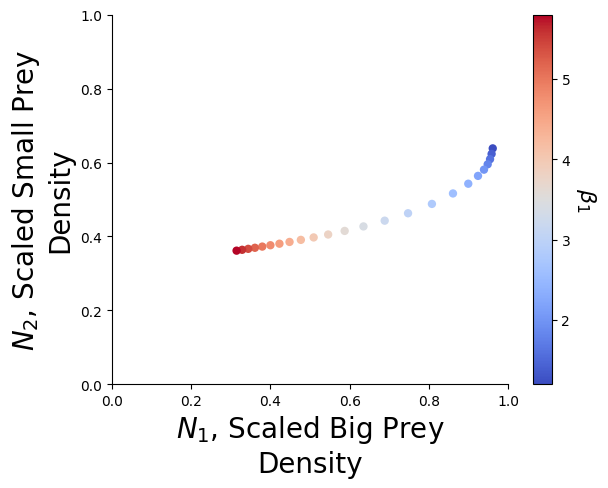

In [12]:
fig, ax = plt.subplots(1,1)
mask = (stability_vec == 1) & (success_vec==1)
p = plt.scatter(N1vec[mask],N2vec[mask], c = β1vec[mask], cmap = 'coolwarm', edgecolor='none')
cb = plt.colorbar(p, label = β1lab)
cb.set_label(label=β1lab, rotation = 270, fontsize = 16, labelpad = 20)
#plt.plot(N1vec,N2vec, 'k')
format_ax(ax,N1lab,N2lab, ylim = [0,1], xlim = [0,1])

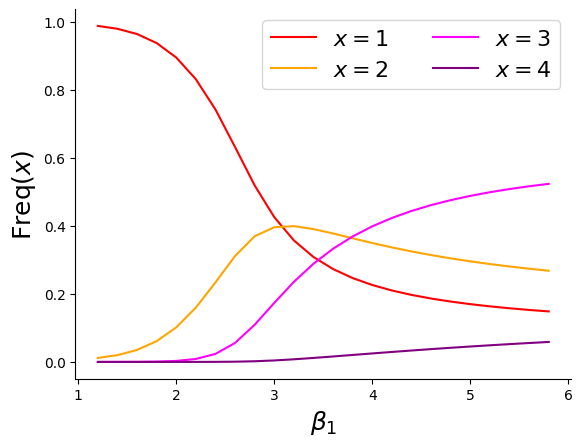

In [13]:
xvec = np.arange(1,x_max+1,1)
freq_x_lab = r'Freq$(x)$'
fig, ax = plot_freq_x_eq(β1vec[mask], Fxvecs[mask], xvec, Pvec[mask], β1lab, 
                       ncol_legend = 2,
                       )

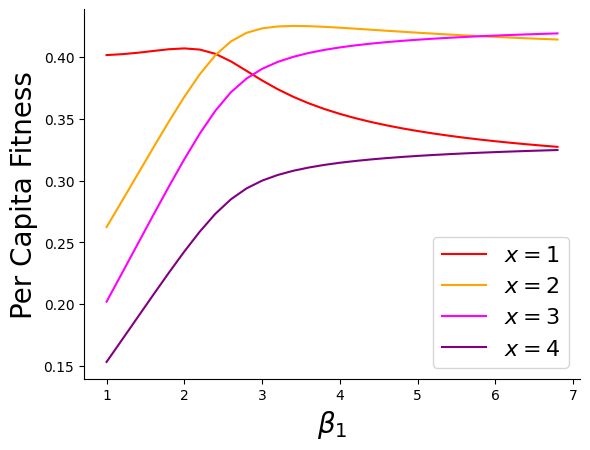

In [13]:
fig,ax = plt.subplots(1,1)
for x in range(1,x_max):
    Wx = []
    for N1,N2,β1 in zip(N1vec[mask], N2vec[mask], β1vec[mask]):
        params = params_base.copy()
        params['β1'] = β1
        Wx.append( per_capita_fitness_from_prey_non_dim(x, N1, N2, **params))
    ax.plot(β1vec[mask],Wx,colors[x-1], label = r'$x = $'+'%d'%x)
    
format_ax(ax, β1lab, 'Per Capita Fitness', if_legend = True, ncol_legend=1)
#fig.savefig(final_fig_path + 'Full_Dyn_beta1_vs_fitness_x.png', **figureops)

## Example Iteration at high $\beta_1$
Note above doesn't show high $\beta_1$ probably because of cycling

In [3]:
params = params_base.copy()
params['β1'] = 8
out2 = solve_ivp(full_model, [0, 2000], [0.5,0.4, *[1,*np.zeros(x_max-1)]], method="LSODA",
                args=(True,params))

2000.0


(0.0, 5.0)

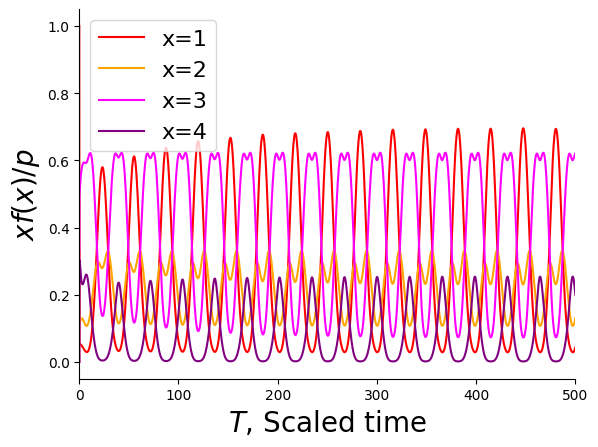

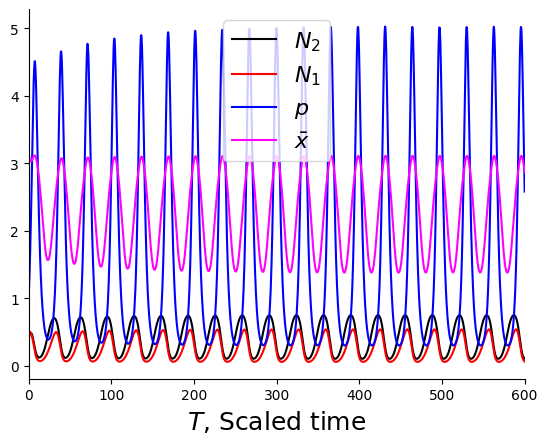

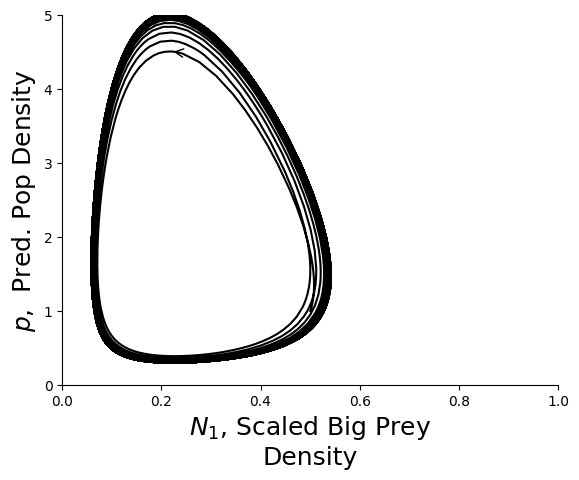

In [4]:
fig, ax = plt.subplots(1,1)
plot_portion_x(fig, ax, out2, x_max=x_max, xlim = [0,500])

T, N1, N2, P, F_of_x_vec, mean_x = get_results(out2,x_max)
plot_all(T,N1,N2,P,mean_x, xlim = [0, 600])
fig, ax = plot_x_vs_y(N1,P,N1lab,Plab,[100])
ax.set_xlim([0,1])
ax.set_ylim([0,5])

# Compare to one group size

(0.0, 1.0)

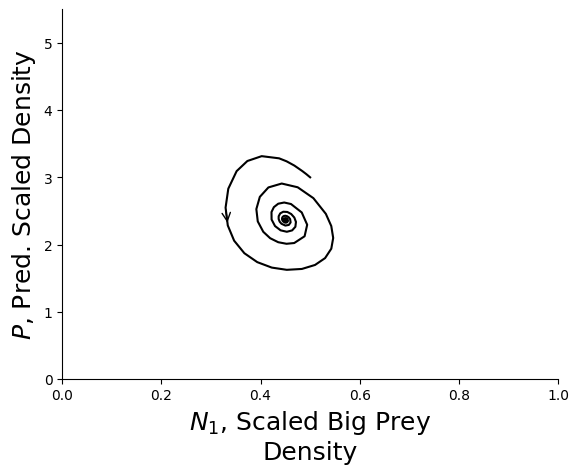

In [10]:
x = 5
Pscaledlab = r'$P$, Pred. Scaled Density'
params = params_base.copy()
params['β1'] = 8
out2 = solve_ivp(model_one_x, [0, 2000], [3,0.5,0.4], method="LSODA",
                args=(x,params))
P, N1, N2 = out2.y
fig, ax = plot_x_vs_y(N1,P,N1lab,Pscaledlab,[10])
ax.set_ylim([0,5.5])
ax.set_xlim([0,1])
#model_one_x(T, initialstate, x, params)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$N_1$, Scaled Big Prey\nDensity', ylabel='$P$, Pred. Scaled Density'>)

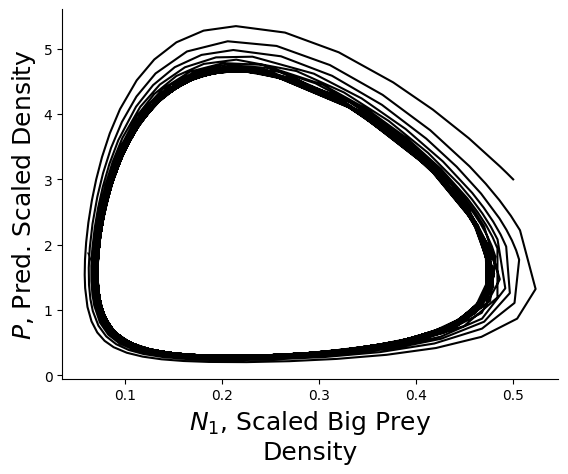

In [11]:
x = 2
params = params_base.copy()
params['β1'] = 8
out2 = solve_ivp(model_one_x, [0, 2000], [3,0.5,0.4], method="LSODA",
                args=(x,params))
P, N1, N2 = out2.y
plot_x_vs_y(N1,P,N1lab,Pscaledlab,[100])
#model_one_x(T, initialstate, x, params)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$N_1$, Scaled Big Prey\nDensity', ylabel='$P$, Scaled Pred. Pop Size'>)

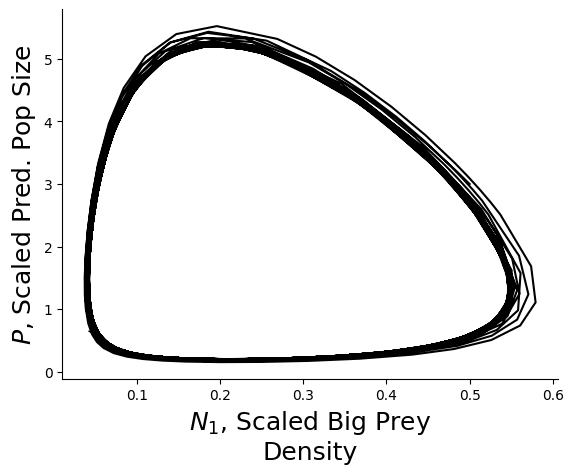